# Importing Packages

In [1]:
import os
import sys
import pylab as plt
import numpy as np
import logging
import importlib
import argparse
import json
import pickle
import yaml
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score
from os.path import expanduser
from aisdc.safemodel.classifiers import SafeSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics



from aisdc.attacks.attack_report_formatter import (  # pylint: disable=import-error
    GenerateTextReport,
)
from aisdc.attacks.likelihood_attack import LIRAAttack  # pylint: disable=import-error
from aisdc.attacks.target import Target  # pylint: disable=import-error
from aisdc.attacks.worst_case_attack import (  # pylint: disable=import-error
    WorstCaseAttack,
)


# Data preperation

## Loading train data

In [2]:
train_data = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv')
train_data = train_data.drop(columns=['Unnamed: 0', 'session_id', 'examination_date', 'earliest_time','rh.aparc.volume','lh.aparc.volume'])
#data = data.set_index('participant_id')
#data[~data.index.duplicated(keep='first')]
train_data = train_data.drop(columns=['participant_id', 'Measure:volume'])

diagnosis_mapping = {'MCI': 0, 'CN': 0, 'AD': 1, 0.666667: 0}
train_data['diagnosis'] = train_data['diagnosis'].map(diagnosis_mapping)

train_data = train_data[(train_data['diagnosis'] == 0) | (train_data['diagnosis'] == 1)]

## Loading test data

In [3]:
test_data = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_test_volumes.tsv')
test_data = test_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'session_id','participant_id','rh.aparc.volume','lh.aparc.volume'])
diagnosis_mapping = {'MCI': 0, 'CN': 0, 'AD': 1}
test_data['diagnosis'] = test_data['diagnosis'].map(diagnosis_mapping)
test_data = test_data[(test_data['diagnosis'] == 0) | (test_data['diagnosis'] == 1)]

## Cleaning data

In [4]:
# Making sure both train and test having same features
common_columns = set(train_data.columns).intersection(set(test_data.columns))
train_data = train_data[common_columns]
test_data = test_data[common_columns]

In [5]:
# Imputing missing values using KNN
imputer = KNNImputer(n_neighbors=3)
train_data = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(imputer.fit_transform(test_data), columns=test_data.columns)

## Split data

In [6]:
X_train = train_data.drop(columns=['diagnosis'])
X_test = test_data.drop(columns=['diagnosis'])
y_train = train_data['diagnosis']
y_test = test_data['diagnosis']

## Over sampling

In [7]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

## Normalizing Data

In [8]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

# SVM Model

## SVM Hyperparameter Optimisation

In [10]:
svm = SVC()

# param_grid = {
#     'kernel': ['linear', 'rbf'],
#     'C': [0.1, 1, 10],
#     'gamma': [0.1, 1, 'scale']
# }

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'scale'],
    'probability': [True]
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=2, scoring='f1', verbose=10)
grid_search.fit(X_train_s, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_


Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2; 1/18] START C=0.1, gamma=0.1, kernel=linear, probability=True..........
[CV 1/2; 1/18] END C=0.1, gamma=0.1, kernel=linear, probability=True;, score=0.804 total time=   0.2s
[CV 2/2; 1/18] START C=0.1, gamma=0.1, kernel=linear, probability=True..........
[CV 2/2; 1/18] END C=0.1, gamma=0.1, kernel=linear, probability=True;, score=0.830 total time=   0.3s
[CV 1/2; 2/18] START C=0.1, gamma=0.1, kernel=rbf, probability=True.............
[CV 1/2; 2/18] END C=0.1, gamma=0.1, kernel=rbf, probability=True;, score=0.666 total time=   0.9s
[CV 2/2; 2/18] START C=0.1, gamma=0.1, kernel=rbf, probability=True.............
[CV 2/2; 2/18] END C=0.1, gamma=0.1, kernel=rbf, probability=True;, score=0.000 total time=   0.9s
[CV 1/2; 3/18] START C=0.1, gamma=1, kernel=linear, probability=True............
[CV 1/2; 3/18] END C=0.1, gamma=1, kernel=linear, probability=True;, score=0.804 total time=   0.4s
[CV 2/2; 3/18] START C=0.1, gamm

In [10]:
print(best_params)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}


In [11]:
print(best_score)

0.8599608421916423


## Final SVM Model & Evaluation

In [12]:
clf = SVC(**best_params)
clf.fit(X_train_s, y_train)
predictions = clf.predict(X_test_s)

In [13]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy*100}")
f1 = f1_score(y_test, predictions)
print(f"F1-Score: {f1*100}")

Accuracy: 75.25
F1-Score: 73.45844504021449


In [14]:
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[164,  36],
       [ 63, 137]], dtype=int64)

## Save Model and Data

In [24]:
directory = "."
# print("Creating directory for training artefacts")

# if not os.path.exists(directory):
# os.makedirs(directory)

In [25]:
print("Saving training/testing data to ./" + directory)
np.savetxt(os.path.join(directory, "x_train.txt"), X_train_s, fmt="%d")
np.savetxt(os.path.join(directory, "y_train.txt"), y_train, fmt="%d")
np.savetxt(os.path.join(directory, "x_test.txt"), X_test_s, fmt="%d")
np.savetxt(os.path.join(directory, "y_test.txt"), y_test, fmt="%d")

Saving training/testing data to ./.


In [26]:
filename = os.path.join(directory, "model.pkl")
print("Saving model to " + filename)
with open(filename, "wb") as file:
    pickle.dump(clf, file)

Saving model to .\model.pkl


# Worst Case Attack

In [27]:
def generate_report(directory, target_model, x_train, y_train,
                                             x_test, y_test, 
                    attack_output_name, target_filename, outfile,):  # pylint: disable=too-many-arguments, disable=too-many-locals
    """Generate report based on target model."""

    print()
    print("Acting as TRE...")
    print()

    if not os.path.exists(directory):
        os.makedirs(directory)

    # Suppress messages from AI-SDC -- comment out these lines to
    # see all the aisdc logging statements
    logging.getLogger("attack-reps").setLevel(logging.WARNING)
    logging.getLogger("prep-attack-data").setLevel(logging.WARNING)
    logging.getLogger("attack-from-preds").setLevel(logging.WARNING)

    # Read the model to be released as supplied by the researcher
    model_filename = os.path.join(directory, target_model)
    print("Reading target model from " + model_filename)
    with open(model_filename, "rb") as file:
        target_model = pickle.load(file)

    # Read the training/testing data as supplied by the researcher
    print("Reading training/testing data from ./" + directory)
    train_x = np.loadtxt(os.path.join(directory, x_train))
    train_y = np.loadtxt(os.path.join(directory, y_train))
    test_x = np.loadtxt(os.path.join(directory, x_test))
    test_y = np.loadtxt(os.path.join(directory, y_test))

    # Wrap the training and test data into the Target object
    target = Target(model=target_model)
    target.add_processed_data(train_x, train_y, test_x, test_y)

    # Run the attack
    wca = WorstCaseAttack(
        n_dummy_reps=10, output_dir=directory, report_name=attack_output_name
    )
    wca.attack(target)

    _ = wca.make_report()

    # Define a configuration file for the attacks to be run
    lira_config = {
        "training_data_filename": "train_data.csv",
        "test_data_filename": "test_data.csv",
        "training_preds_filename": "train_preds.csv",
        "test_preds_filename": "test_preds.csv",
        "target_model": ["sklearn.svm"],
        "target_model_hyp": {"C": 10, "gamma": 'scale'},
    }

    with open(
        os.path.join(directory, "lira_config.json"), "w", encoding="utf-8"
    ) as file:
        file.write(json.dumps(lira_config))

    # Run the LIRA attack to test disclosure risk
    lira_attack_obj = LIRAAttack(
        n_shadow_models=100,
        attack_config_json_file_name=os.path.join(directory, "lira_config.json"),
        output_dir=directory,
        report_name=attack_output_name,
    )

    lira_attack_obj.attack(target)
    _ = lira_attack_obj.make_report()

    target.save(os.path.join(directory, "target"))

    text_report = GenerateTextReport()
    text_report.process_attack_target_json(
        os.path.join(directory, attack_output_name) + ".json",
        target_filename=os.path.join(directory, "target", target_filename),
    )

    text_report.export_to_file(
        output_filename=os.path.join(directory, outfile),
        move_files=True,
        model_filename=model_filename,
    )

    print("Results written to " + os.path.join(directory, outfile))

In [28]:
def run_user_story(release_config: dict):
    """Main method to parse arguments and then invoke report generation."""

    generate_report(
        release_config["training_artefacts_dir"],
        release_config["target_model"],
        release_config["x_train_path"],
        release_config["y_train_path"],
        release_config["x_test_path"],
        release_config["y_test_path"],
        release_config["attack_output_name"],
        release_config["target_results"],
        release_config["outfile"],
    )


Acting as TRE...

Reading target model from .\model.pkl
Reading training/testing data from ./.


INFO:_check_and_update_dataset:new ytrain has values and counts: (array([0, 1]), array([1407, 1407], dtype=int64))
INFO:_check_and_update_dataset:new ytest has values and counts: (array([0, 1]), array([200, 200], dtype=int64))
INFO:lr-scenario:Training shadow models
INFO:lr-scenario:Trained 0 models
INFO:lr-scenario:Trained 10 models
INFO:lr-scenario:Trained 20 models
INFO:lr-scenario:Trained 30 models
INFO:lr-scenario:Trained 40 models
INFO:lr-scenario:Trained 50 models
INFO:lr-scenario:Trained 60 models
INFO:lr-scenario:Trained 70 models
INFO:lr-scenario:Trained 80 models
INFO:lr-scenario:Trained 90 models
INFO:lr-scenario:Computing scores for train rows
INFO:lr-scenario:Computing scores for shadow rows
INFO:lr-scenario:Finished scenario
INFO:reporting:Starting reports, pdf report name = .\attack_output.pdf, json report name = .\attack_output.json
INFO:reporting:Wrote pdf report to .\attack_output.pdf and json report to .\attack_output.json


Results written to .\summary.txt


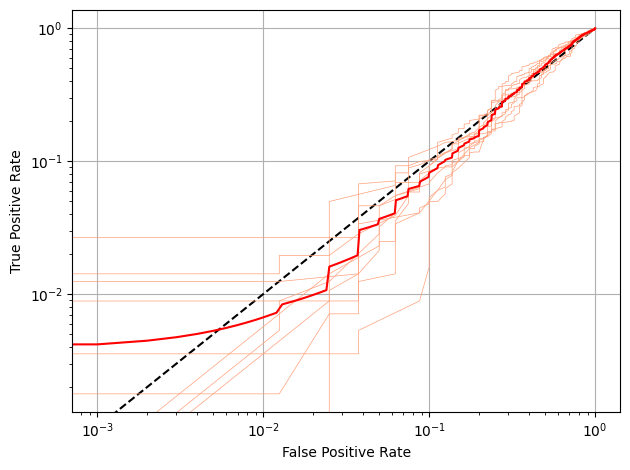

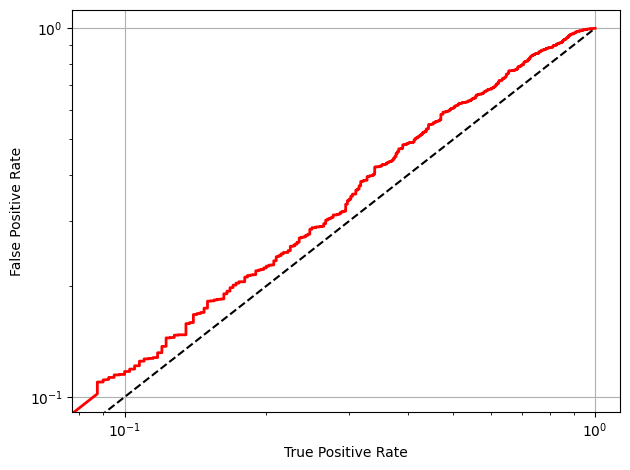

In [31]:
config = {
    'user_story': 3,
    'dataset_filename': 'C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv',
    'target_model': "model.pkl",
    'outfile': "summary.txt",
    'attack_results': "attack_results.json",
    'training_artefacts_dir': ".",
    'target_results': "target.json",
    'x_train_path': "x_train.txt",
    'y_train_path': "y_train.txt",
    'x_test_path': "x_test.txt",
    'y_test_path': "y_test.txt",
    'attack_output_name': "attack_output"
}

run_user_story(config)

# Safe Model

## Run Safe model to Check

In [11]:
C = best_params['C']
gamma = best_params['gamma']
clf3 = SafeSVC(C=C, gamma=gamma)
clf3.fit(X_train_s, np.ravel(y_train,order="c"))
c3 = clf3.predict(X_test_s)
p3 = clf3.predict_proba(X_test_s)

In [16]:
clf3.save(name="testSaveSVC.pkl")
clf3.preliminary_check()
clf3.request_release(path="testSaveSVC", ext="pkl")
target_json = os.path.normpath("testSaveSVC/target.json")
with open(target_json, "r") as f:
    print(f.read())

Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter gamma = 0.0075757575757575794 identified as less than the recommended min value of 0.1.
{
    "data_name": "",
    "n_samples": 0,
    "features": {},
    "n_features": 0,
    "n_samples_orig": 0,
    "generalisation_error": "unknown",
    "safemodel": [
        {
            "researcher": "alieyeh.moghaddam",
            "model_type": "SVC",
            "details": "WARNING: model parameters may present a disclosure risk:\n- parameter gamma = 0.0075757575757575794 identified as less than the recommended min value of 0.1.",
            "recommendation": "Do not allow release",
            "reason": "WARNING: model parameters may present a disclosure risk:\n- parameter gamma = 0.0075757575757575794 identified as less than the recommended min value of 0.1.",
            "timestamp": "2023-12-19 10:28:56"
        }
    ],
    "model_path": "model.pkl",
    "model_name": "SafeSVC",
    "model_params": {

In [17]:
print("Accuracy:", metrics.accuracy_score(y_test, c3)*100)
print("Precision:", metrics.precision_score(y_test, c3)*100)
print("Recall:", metrics.recall_score(y_test, c3)*100)
print("F1-score:", metrics.f1_score(y_test, c3)*100)

Accuracy: 53.25
Precision: 52.18855218855219
Recall: 77.5
F1-score: 62.37424547283702


Saving model to ./old_safe\model2.pkl

Acting as TRE...
(when instructions on how to recreate the dataset have been provided by the researcher)
./old_safe

Reading target model from ./old_safe\model2.pkl
===> now running attacks implicitly via request_release()


INFO:attack-from-preds:Running main attack repetitions
INFO:prep-attack-data:Sorting probabilities to leave highest value in first column
INFO:prep-attack-data:Creating MIA data
INFO:attack-reps:Rep 1 of 10 split 5
INFO:attack-reps:Rep 2 of 10 split 25
INFO:attack-reps:Rep 3 of 10 split 36
INFO:attack-reps:Rep 4 of 10 split 49
INFO:attack-reps:Rep 5 of 10 split 64
INFO:attack-reps:Rep 6 of 10 split 81
INFO:attack-reps:Rep 7 of 10 split 100
INFO:attack-reps:Rep 8 of 10 split 121
INFO:attack-reps:Rep 9 of 10 split 144
INFO:attack-reps:Rep 10 of 10 split 169
INFO:attack-reps:Finished simulating attacks
INFO:attack-from-preds:Running dummy attack reps
INFO:prep-attack-data:Sorting probabilities to leave highest value in first column
INFO:prep-attack-data:Creating MIA data
INFO:attack-reps:Rep 1 of 10 split 5
INFO:attack-reps:Rep 2 of 10 split 25
INFO:attack-reps:Rep 3 of 10 split 36
INFO:attack-reps:Rep 4 of 10 split 49
INFO:attack-reps:Rep 5 of 10 split 64
INFO:attack-reps:Rep 6 of 10 spl

attack worst_case, metadata {'experiment_details': {'n_reps': 10, 'reproduce_split': [5, 25, 36, 49, 64, 81, 100, 121, 144, 169], 'p_thresh': 0.05, 'n_dummy_reps': 1, 'train_beta': 1, 'test_beta': 1, 'test_prop': 0.5, 'n_rows_in': 2814, 'n_rows_out': 400, 'training_preds_filename': None, 'test_preds_filename': None, 'output_dir': './old_safe', 'report_name': 'attack_results', 'include_model_correct_feature': False, 'sort_probs': True, 'mia_attack_model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'mia_attack_model_hyp': {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 5}, 'attack_metric_success_name': 'P_HIGHER_AUC', 'attack_metric_success_thresh': 0.05, 'attack_metric_success_comp_type': 'lte', 'attack_metric_success_count_thresh': 5, 'attack_fail_fast': False, 'attack_config_json_file_name': None, 'target_path': None}, 'attack': 'WorstCase attack', 'global_metrics': {'null_auc_3sd_range': '0.4345 -> 0.5655', 'n_sig_auc_p_vals': 1, 'n_sig_auc_p_vals_corre

INFO:lr-scenario:Training shadow models
INFO:lr-scenario:Trained 0 models
INFO:lr-scenario:Trained 10 models
INFO:lr-scenario:Trained 20 models
INFO:lr-scenario:Trained 30 models
INFO:lr-scenario:Trained 40 models
INFO:lr-scenario:Trained 50 models
INFO:lr-scenario:Trained 60 models
INFO:lr-scenario:Trained 70 models
INFO:lr-scenario:Trained 80 models
INFO:lr-scenario:Trained 90 models
INFO:lr-scenario:Computing scores for train rows
INFO:lr-scenario:Computing scores for shadow rows
INFO:lr-scenario:Finished scenario
INFO:reporting:Starting reports, pdf report name = ./old_safe\attack_results.pdf, json report name = ./old_safe\attack_results.json
INFO:reporting:Wrote pdf report to ./old_safe\attack_results.pdf and json report to ./old_safe\attack_results.json
INFO:aia:Starting reports, pdf report name = ./old_safe\attack_results.pdf, json report name = ./old_safe\attack_results.json


attack lira, metadata {'experiment_details': {'n_shadow_models': 100, 'p_thresh': 0.05, 'output_dir': './old_safe', 'report_name': 'attack_results', 'training_data_filename': None, 'test_data_filename': None, 'training_preds_filename': None, 'test_preds_filename': None, 'target_model': None, 'target_model_hyp': None, 'attack_config_json_file_name': None, 'n_shadow_rows_confidences_min': 10, 'shadow_models_fail_fast': False, 'target_path': None}, 'global_metrics': {'PDIF_sig': 'Not significant at p=0.05', 'AUC_sig': 'Significant at p=0.05', 'null_auc_3sd_range': '0.45371619255553297 -> 0.546283807444467'}, 'attack': 'LIRA Attack'}


INFO:aia:Wrote pdf report to ./old_safe\attack_results.pdf and json report to ./old_safe\attack_results.json


attack attribute, metadata {'experiment_details': {'output_dir': './old_safe', 'report_name': 'attack_results', 'n_cpu': 11, 'attack_config_json_file_name': None, 'target_path': None}, 'attack': 'Attribute inference attack'}
Please see the files generated in: ./old_safe
Results written to ./old_safe\summary.txt


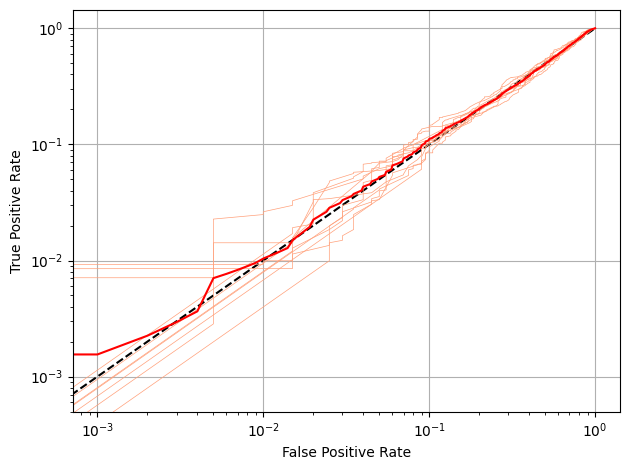

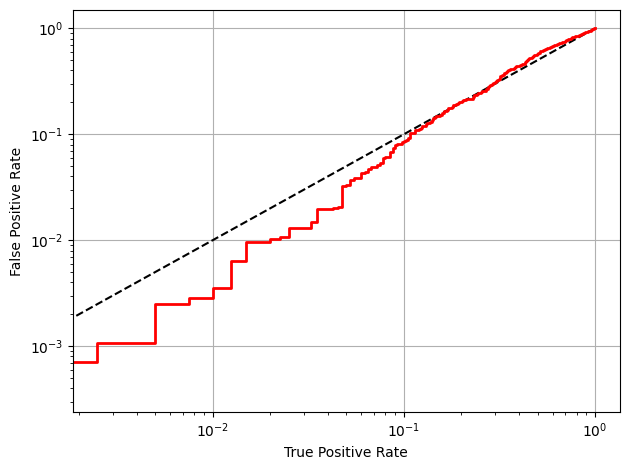

In [14]:
directory = './old_safe'
filename = os.path.join(directory, "model2.pkl")
print("Saving model to " + filename)
with open(filename, "wb") as file:
    pickle.dump(clf3, file)
def generate_report(
    # data_processing_filename,
    # data_processing_function_name,
    # dataset_filename,
    directory,
    target_model,
    attack_results,
    target_filename,
    outfile,
    X_train, X_test, y_train, y_test,
):  # pylint: disable=too-many-locals, disable=too-many-arguments
    """Generate report based on target model."""

    print()
    print("Acting as TRE...")
    print(
        "(when instructions on how to recreate the dataset have been provided by the researcher)"
    )
    print(directory)
    print()

    # Read in the model supplied by the researcher
    filename = os.path.join(directory, target_model)
    print("Reading target model from " + filename)
    with open(filename, "rb") as f:
        target_model = pickle.load(f)

    # x_train, x_test, Y_train, Y_test = process_dataset(X_train, X_test, y_train, y_test)

    # Wrap the model and data in a Target object
    target = Target(model=target_model)
    target.add_processed_data(X_train, y_train, X_test, y_test)

    # TRE calls request_release()
    print("===> now running attacks implicitly via request_release()")
    target_model.request_release(path=directory, ext="pkl", target=target)

    print(f"Please see the files generated in: {directory}")

    # Generate a report indicating calculated disclosure risk
    text_report = GenerateTextReport()
    text_report.process_attack_target_json(
        os.path.join(directory, attack_results),
        target_filename=os.path.join(directory, target_filename),
    )

    text_report.export_to_file(
        output_filename=os.path.join(directory, outfile), move_files=True
    )

    print("Results written to " + str(os.path.join(directory, outfile)))
def run_user_story(release_config: dict):
    """Main method to parse arguments and then invoke report generation."""

    generate_report(
        # release_config["data_processing_filename"],
        # release_config["data_processing_function_name"],
        # release_config["dataset_filename"],
        release_config["training_artefacts_dir"],
        release_config["target_model"],
        release_config["attack_results"],
        release_config["target_results"],
        release_config["outfile"],
        X_train_s, X_test_s, y_train, y_test,
    )

config = {
    'user_story': 2,
    'dataset_filename': 'C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv',
    'target_model': "model2.pkl",
    'outfile': "summary.txt",
    'attack_results': "attack_results.json",
    'training_artefacts_dir': "./old_safe",
    'target_results': "target.json",
    'data_processing_filename': './data_processing_researcher.py',
    'data_processing_function_name': 'process_dataset'
}

run_user_story(config)

## Change Params to Safe Range

In [18]:
clf3 = SafeSVC(C=C, gamma=1)
clf3.fit(X_train_s, np.ravel(y_train,order="c"))
c3 = clf3.predict(X_test_s)
p3 = clf3.predict_proba(X_test_s)

In [19]:
#worst case, membership inference
clf3.save(name="testSaveSVC.pkl")
clf3.request_release(path="testSaveSVC", ext="pkl")
clf3.preliminary_check()
target_json = os.path.normpath("testSaveSVC/target.json")
with open(target_json, "r") as f:
    print(f.read())

Preliminary checks: Model parameters are within recommended ranges.

{
    "data_name": "",
    "n_samples": 0,
    "features": {},
    "n_features": 0,
    "n_samples_orig": 0,
    "generalisation_error": "unknown",
    "safemodel": [
        {
            "researcher": "alieyeh.moghaddam",
            "model_type": "SVC",
            "details": "Model parameters are within recommended ranges.\n",
            "recommendation": "Proceed to next step of checking",
            "timestamp": "2023-12-19 10:29:09"
        }
    ],
    "model_path": "model.pkl",
    "model_name": "SafeSVC",
    "model_params": {}
}


In [20]:
print("Accuracy:", metrics.accuracy_score(y_test, c3)*100)
print("Precision:", metrics.precision_score(y_test, c3)*100)
print("Recall:", metrics.recall_score(y_test, c3)*100)
print("F1-score:", metrics.f1_score(y_test, c3)*100)

Accuracy: 48.5
Precision: 48.58490566037736
Recall: 51.5
F1-score: 50.0


## Worst Case Attack

In [21]:
import json
import os
import sys
from aisdc.attacks import worst_case_attack  
from aisdc.attacks.target import Target 

### On Normal SVM Model

In [22]:
target = Target(model=clf)
target.add_processed_data(X_train_s, y_train, X_test_s, y_test)

In [63]:
# Create the attack object
attack_obj = worst_case_attack.WorstCaseAttack(
    n_reps=10,
    n_dummy_reps=1,
    train_beta=5,
    test_beta=2,
    p_thresh=0.05,
    training_preds_filename=None,
    test_preds_filename=None,
    test_prop=0.5,
    output_dir="outputs_worstcase_safe_newdata1",
    attack_metric_success_name="P_HIGHER_AUC",
    attack_metric_success_thresh=0.05,
    attack_metric_success_comp_type="lte",
    attack_metric_success_count_thresh=2,
    attack_fail_fast=True,
)

In [64]:
# Run the attack
attack_obj.attack(target)

INFO:attack-from-preds:Running main attack repetitions
INFO:prep-attack-data:Sorting probabilities to leave highest value in first column
INFO:prep-attack-data:Creating MIA data
INFO:attack-reps:Rep 1 of 10 split 5
INFO:attack-reps:Rep 2 of 10 split 25
INFO:attack-reps:Finished simulating attacks
INFO:attack-from-preds:Running dummy attack reps
INFO:prep-attack-data:Sorting probabilities to leave highest value in first column
INFO:prep-attack-data:Creating MIA data
INFO:attack-reps:Rep 1 of 10 split 5
INFO:attack-reps:Rep 2 of 10 split 25
INFO:attack-reps:Finished simulating attacks
INFO:attack-from-preds:Finished running attacks


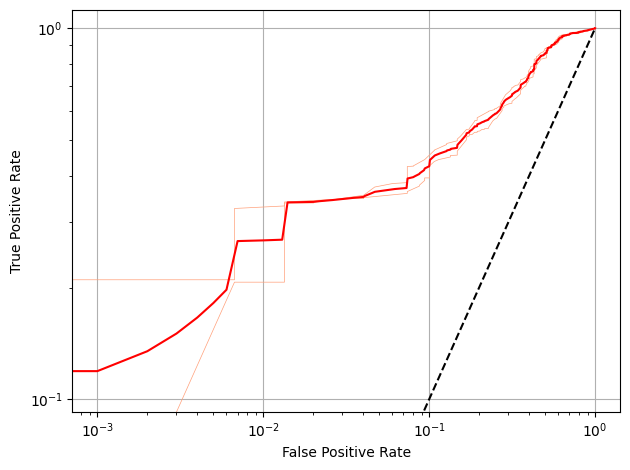

In [65]:
# Grab the output
output = attack_obj.make_report()
metadata = output["metadata"]

In [67]:
print(
    "Number of significant AUC values (raw):",
    f"{metadata['global_metrics']['n_sig_auc_p_vals']}/{attack_obj.n_reps}",
)

print(
    "Number of significant AUC values (FDR corrected):",
    f"{metadata['global_metrics']['n_sig_auc_p_vals_corrected']}/{attack_obj.n_reps}",
)

print(
    "Number of significant PDIF values (proportion of 0.1), raw:",
    f"{metadata['global_metrics']['n_sig_pdif_vals']}/{attack_obj.n_reps}",
)

print(
    "Number of significant PDIF values (proportion of 0.1), FDR corrected:",
    f"{metadata['global_metrics']['n_sig_pdif_vals_corrected']}/{attack_obj.n_reps}",
)

print(
    "(dummy) Number of significant AUC values (raw):",
    f"{metadata['baseline_global_metrics']['n_sig_auc_p_vals']}/{attack_obj.n_reps}",
)

print(
    "(dummy) Number of significant AUC values (FDR corrected):",
    f"{metadata['baseline_global_metrics']['n_sig_auc_p_vals_corrected']}/{attack_obj.n_reps}",
)



Number of significant AUC values (raw): 2/10
Number of significant AUC values (FDR corrected): 2/10
Number of significant PDIF values (proportion of 0.1), raw: 2/10
Number of significant PDIF values (proportion of 0.1), FDR corrected: 2/10
(dummy) Number of significant AUC values (raw): 2/10
(dummy) Number of significant AUC values (FDR corrected): 2/10


### On Safe SVM Model

In [68]:
target = Target(model=clf3)
target.add_processed_data(X_train_s, y_train, X_test_s, y_test)

In [69]:
# Create the attack object
attack_obj = worst_case_attack.WorstCaseAttack(
    n_reps=10,
    n_dummy_reps=1,
    train_beta=5,
    test_beta=2,
    p_thresh=0.05,
    training_preds_filename=None,
    test_preds_filename=None,
    test_prop=0.5,
    output_dir="outputs_worstcase_safe_newdata1",
    attack_metric_success_name="P_HIGHER_AUC",
    attack_metric_success_thresh=0.05,
    attack_metric_success_comp_type="lte",
    attack_metric_success_count_thresh=2,
    attack_fail_fast=True,
)

In [70]:
attack_obj.attack(target)

INFO:attack-from-preds:Running main attack repetitions
INFO:prep-attack-data:Sorting probabilities to leave highest value in first column
INFO:prep-attack-data:Creating MIA data
INFO:attack-reps:Rep 1 of 10 split 5
INFO:attack-reps:Rep 2 of 10 split 25
INFO:attack-reps:Rep 3 of 10 split 36
INFO:attack-reps:Rep 4 of 10 split 49
INFO:attack-reps:Rep 5 of 10 split 64
INFO:attack-reps:Rep 6 of 10 split 81
INFO:attack-reps:Rep 7 of 10 split 100
INFO:attack-reps:Rep 8 of 10 split 121
INFO:attack-reps:Rep 9 of 10 split 144
INFO:attack-reps:Rep 10 of 10 split 169
INFO:attack-reps:Finished simulating attacks
INFO:attack-from-preds:Running dummy attack reps
INFO:prep-attack-data:Sorting probabilities to leave highest value in first column
INFO:prep-attack-data:Creating MIA data
INFO:attack-reps:Rep 1 of 10 split 5
INFO:attack-reps:Rep 2 of 10 split 25
INFO:attack-reps:Finished simulating attacks
INFO:attack-from-preds:Finished running attacks


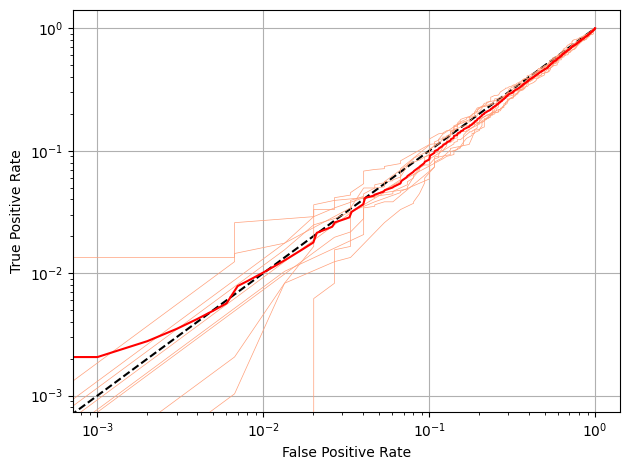

In [71]:
# Grab the output
output = attack_obj.make_report()
metadata = output["metadata"]

In [72]:
print(
    "Number of significant AUC values (raw):",
    f"{metadata['global_metrics']['n_sig_auc_p_vals']}/{attack_obj.n_reps}",
)

print(
    "Number of significant AUC values (FDR corrected):",
    f"{metadata['global_metrics']['n_sig_auc_p_vals_corrected']}/{attack_obj.n_reps}",
)

print(
    "Number of significant PDIF values (proportion of 0.1), raw:",
    f"{metadata['global_metrics']['n_sig_pdif_vals']}/{attack_obj.n_reps}",
)

print(
    "Number of significant PDIF values (proportion of 0.1), FDR corrected:",
    f"{metadata['global_metrics']['n_sig_pdif_vals_corrected']}/{attack_obj.n_reps}",
)

print(
    "(dummy) Number of significant AUC values (raw):",
    f"{metadata['baseline_global_metrics']['n_sig_auc_p_vals']}/{attack_obj.n_reps}",
)

print(
    "(dummy) Number of significant AUC values (FDR corrected):",
    f"{metadata['baseline_global_metrics']['n_sig_auc_p_vals_corrected']}/{attack_obj.n_reps}",
)

print('')
print("End of Example 1")
print("********************************")

Number of significant AUC values (raw): 0/10
Number of significant AUC values (FDR corrected): 0/10
Number of significant PDIF values (proportion of 0.1), raw: 0/10
Number of significant PDIF values (proportion of 0.1), FDR corrected: 0/10
(dummy) Number of significant AUC values (raw): 2/10
(dummy) Number of significant AUC values (FDR corrected): 2/10

End of Example 1
********************************


## Structural Attack

### On Normal SVM Model

In [86]:
import aisdc.attacks.structural_attack as sa

In [96]:
target = Target(model=clf)
target.add_processed_data(X_train_s, y_train, X_test_s, y_test)

In [ ]:
# assert sa.get_unnecessary_risk(clf) == 0

In [98]:
myattack = sa.StructuralAttack()
myattack.attack(target)
    # remove model
# target.model = None
# with pytest.raises(NotImplementedError):
#     myattack2 = sa.StructuralAttack()
#     myattack2.attack(target)

INFO:acro:version: 0.4.3
INFO:acro:config: {'safe_threshold': 10, 'safe_dof_threshold': 10, 'safe_nk_n': 2, 'safe_nk_k': 0.9, 'safe_pratio_p': 0.1, 'check_missing_values': False, 'survival_safe_threshold': 10}
INFO:acro:automatic suppression: False
INFO:structural_attack:Thresholds for count 10 and Dof 10


equiv_classes is [[2.08820925e-08 9.99999979e-01]
 [3.32480333e-08 9.99999967e-01]
 [2.62239488e-07 9.99999738e-01]
 ...
 [9.99961710e-01 3.82895698e-05]
 [9.99962243e-01 3.77570469e-05]
 [9.99979586e-01 2.04140492e-05]]
equiv_counts is [1 1 1 ... 1 1 1]



In [100]:
output = myattack.make_report()
metadata = output["metadata"]
metadata

{'experiment_details': {'attack_config_json_file_name': None,
  'risk_appetite_config': 'default',
  'target_path': None,
  'output_dir': 'outputs_structural',
  'report_name': 'report_structural'},
 'attack': 'Structural attack',
 'global_metrics': {'DoF_risk': 0,
  'k_anonymity_risk': 1,
  'class_disclosure_risk': 1,
  'unnecessary_risk': 0,
  'lowvals_cd_risk': 1}}

### On Safe SVM Model

In [101]:
target = Target(model=clf3)
target.add_processed_data(X_train_s, y_train, X_test_s, y_test)

In [102]:
myattack = sa.StructuralAttack()
myattack.attack(target)

INFO:acro:version: 0.4.3
INFO:acro:config: {'safe_threshold': 10, 'safe_dof_threshold': 10, 'safe_nk_n': 2, 'safe_nk_k': 0.9, 'safe_pratio_p': 0.1, 'check_missing_values': False, 'survival_safe_threshold': 10}
INFO:acro:automatic suppression: False
INFO:structural_attack:Thresholds for count 10 and Dof 10


equiv_classes is [[0.70335876 0.29664124]
 [0.7061877  0.2938123 ]
 [0.7064059  0.2935941 ]
 ...
 [0.74872218 0.25127782]
 [0.75123801 0.24876199]
 [0.75224466 0.24775534]]
equiv_counts is [1 1 1 ... 1 1 1]



In [103]:
output = myattack.make_report()
metadata = output["metadata"]
metadata

{'experiment_details': {'attack_config_json_file_name': None,
  'risk_appetite_config': 'default',
  'target_path': None,
  'output_dir': 'outputs_structural',
  'report_name': 'report_structural'},
 'attack': 'Structural attack',
 'global_metrics': {'DoF_risk': 0,
  'k_anonymity_risk': 1,
  'class_disclosure_risk': 1,
  'unnecessary_risk': 0,
  'lowvals_cd_risk': 1}}